# The goal here is to investigate the NPQ behaviour in 4 variants of the model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from scipy.optimize import minimize

plt.style.use("./notebook.mplstyle")
print(modelbase.__version__)

1.3.6


In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture
cd analyses/

## Build the photosynthesis model with ROS producing and scavenging mechanisms
add_mehler():
- adds 7 reactions to the model,
- updates algebraic module calculating the PS1 excitation states

In [5]:
m = get_model()

In [6]:
# I like to have light as a derived variable
m.add_algebraic_module(
    module_name = "Light",
    function = lambda X, PFD: PFD ,
    compounds = ["PQ"],
    derived_compounds = ["L"],
    parameters = ['pfd'])

In [7]:
# provide starting consitions for the model
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

# Helper functions
- PAM fluorescence light protocol
- get NPQ

In [8]:
def get_NPQ(F, t, lights, maxlight=5000):
    """Calculates the NPQ from the extracted important points of the PAM simulations


    Parameters
    ----------
    F : numpy.array or list
        Simulated fluorescence values of PAM experiment
    t : numpy.array or list
        Time points of simulated PAM experiment
    lights : numpy.array or list
        PFD values for each time point
    maxlight : int
       PFD of saturating light impuls


    Returns
    -------
    Fm : list
        Fm (first element of list) and Fm' values
    NPQ : list
        Calculated NPQ values
    tm : list
        Exact time points of peaks in PAM trace
    Fo : list
        Fo (first element of list) and Ft' values
    to : list
        Exact time points of Fo and Ft' values

    """
    z = (
        []
    )  # container for lists. Each list contains the positions of fluorescence values for one peak
    o = []  # container for position of Fo'
    cnt = 0
    while cnt < len(lights):
        if lights[cnt] == maxlight:
            h = (
                []
            )  # temporary container for all F==maxlight. For each peak it is renewed
            while cnt != len(lights) and lights[cnt] == maxlight:
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0] - 1)  # value directly at the bottom of peak is Fo
        else:
            cnt += 1
    peaks = [
        i[np.argmax(F[i])] for i in z
    ]  # Fm is the maximal value for each peak sequence
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm) / Fm
    return Fm, NPQ, tm, Fo, to

In [9]:
def changingLight(
    model, y0d, PFD=125.0, dark_light_intensity=30.0, sat_pulse_intensity=1100.0
):
    r"""Performs PAM light-dim light simulation for given light intensity.

    The length of the experiment is fixed to the length of accompanying lab experiments

    Parameters
    ----------
    model : modelbase object
    y0d : numpy.array or list
        initial concentrations of compounds
    PFD : int
        light intensity
    dark : int
        intensity of the dim phase set to 0 as default


    Returns
    -------
    s : modelbase object
        contains results of the simulation

    """
    tprot = np.array(
        [1.0, 0.8]
        + [2.0, 0.8]
        + [5, 0.8] * 2
        + [15.86666667, 0.8]
        + [30.86666667, 0.8] * 11
        + [15.53333333, 0.8]
        + [30.86666667, 0.8] * 15
    )

    ProtPFDs = np.array(
        [dark_light_intensity, sat_pulse_intensity] * 2
        + [PFD, sat_pulse_intensity] * 14
        + [dark_light_intensity, sat_pulse_intensity] * 16
    )

    s = Simulator(model)
    s.initialise(y0d)
    dt = 0
    for t, pfd in tqdm(zip(tprot, ProtPFDs), total=len(tprot), desc="Simulation step"):
        s.update_parameter("pfd", pfd)
        dt += t
        s.simulate(dt, **{"rtol": 1e-10, "atol": 1e-10, "maxnef": 20, "maxncf": 10})
    return s

# Run light-dark PAM
Simulate five experiments with light-dark phases with PAM pulses.

Experiment:   0%|          | 0/2 [00:00<?, ?it/s]

Simulation step:   0%|          | 0/64 [00:00<?, ?it/s]

Simulation step:   0%|          | 0/64 [00:00<?, ?it/s]

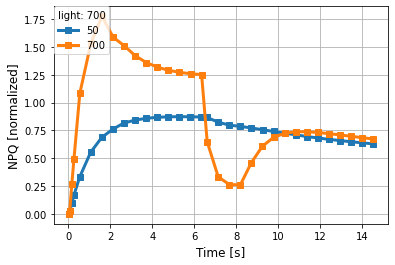

In [10]:
data = {}
# lls = [50, 100, 200, 500, 700]
lls = [50, 700]
for ll in tqdm(lls, total=len(lls), desc="Experiment"):
    m.update_parameters({"pfd": ll, "kH0": 0})
    s = Simulator(m)
    s.initialise(y0)
    # dark adaptation: making sure that the initial conditions are representing
    # healthy state of the diatom with oxidised PQ pool and no active quencher
    s.update_parameters({"pfd": 30.0})
    s.simulate(1000, steps=3000, **{"atol": 1e-8})
    y0d = s.get_results_array()[-1]
    PAM1 = changingLight(
        m, y0d, PFD=ll, dark_light_intensity=30.0, sat_pulse_intensity=1100.0
    )
    F = PAM1.get_variable("Fluo")
    Fm, NPQ, tm, Fo, to = get_NPQ(
        PAM1.get_variable("Fluo"), PAM1.get_time(), PAM1.get_variable("L"), 1100
    )
    plt.plot(tm / 60.0, NPQ, "s-", label=str(ll))
    plt.xlabel("Time [s]")
    plt.ylabel("NPQ [normalized]")
    data[ll] = {
        "time": PAM1.get_time(),
        "results": PAM1.get_full_results_df(),
        "fluxes": PAM1.get_fluxes_df(),
    }

plt.legend(title="light: " + str(ll))
plt.show()

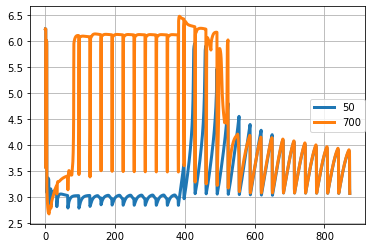

In [11]:
for k in data.keys():
    plt.plot(data[k]['time'], data[k]['results']['pH'], label=k)
plt.legend(loc='right')

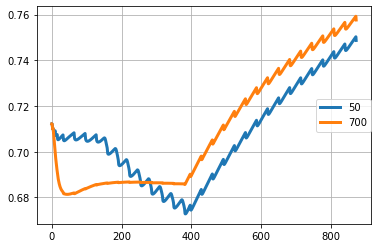

In [12]:
for k in data.keys():
    plt.plot(data[k]['time'], data[k]['results']['LHC'], label=k)
plt.legend(loc='right')

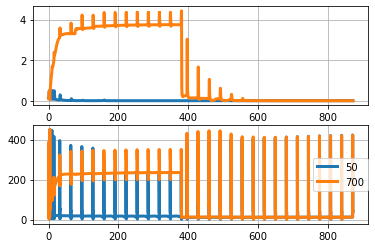

In [13]:
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
for k in data.keys():
    ax1.plot(data[k]['time'], data[k]['fluxes']['vRuBisCO'], label=k)
for k in data.keys():
    ax2.plot(data[k]['time'], data[k]['fluxes']['vPS2'], label=k)
plt.legend(loc='right')